In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models import vgg19, VGG19_Weights

# 1. Set data

## 1-1. load images

In [2]:
style_img_path = "./notebook_images/picasso.jpg"
content_img_path = "./notebook_images/dancing.jpg"

style_img = Image.open(style_img_path)
content_img = Image.open(content_img_path)

## 1-2. Transform as tensor

In [3]:
img_size = 128

ImageNet_mean = [0.485, 0.456, 0.406]
ImageNet_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=ImageNet_mean, std=ImageNet_std)
])

In [4]:
style_tensor = transform(style_img)
content_tensor = transform(content_img)

print(f"style_tensor shape: {style_tensor.shape}")
print(f"content_tensor shape: {content_tensor.shape}")

style_tensor shape: torch.Size([3, 128, 128])
content_tensor shape: torch.Size([3, 128, 128])


## 1-3. Add batch size

In [5]:
style_tensor = style_tensor.unsqueeze(0)
content_tensor = content_tensor.unsqueeze(0)

print(f"style_tensor shape: {style_tensor.shape}")
print(f"content_tensor shape: {content_tensor.shape}")

style_tensor shape: torch.Size([1, 3, 128, 128])
content_tensor shape: torch.Size([1, 3, 128, 128])


## 1-4. Make noise tensor

In [6]:
noise_tensor = torch.randn(style_tensor.size())
print(f"noise_tensor shape: {noise_tensor.shape}")

noise_tensor shape: torch.Size([1, 3, 128, 128])


## 1-5. Visualize data

In [7]:
untransform = transforms.Compose([
    transforms.Normalize(
        mean=[-m / s for m, s in zip(ImageNet_mean, ImageNet_std)],
        std=[1 / s for s in ImageNet_std]
    ),
    transforms.ToPILImage(),
])

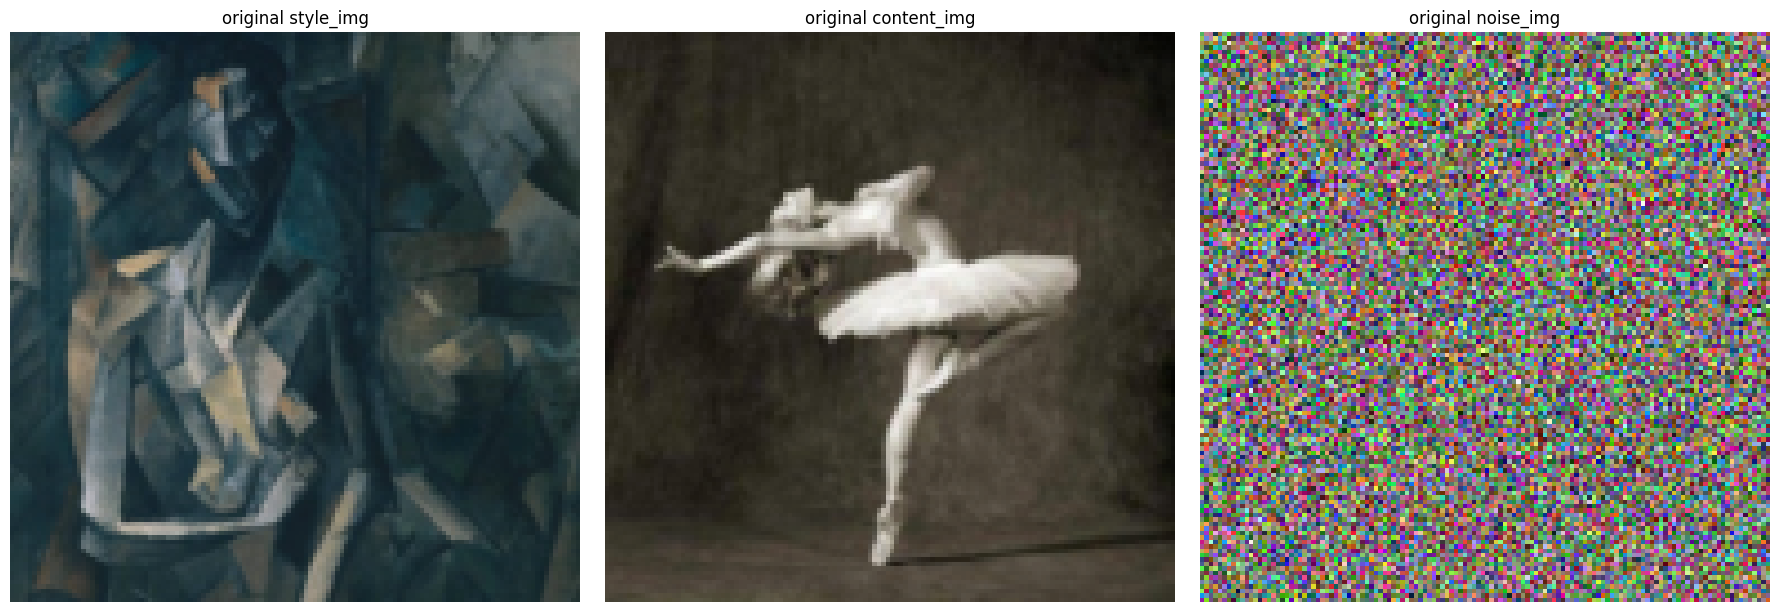

In [8]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(untransform(style_tensor.squeeze(0)))
plt.title(f"original style_img")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(untransform(content_tensor.squeeze(0)))
plt.title(f"original content_img")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(untransform(noise_tensor.squeeze(0)))
plt.title(f"original noise_img")
plt.axis("off")

plt.tight_layout()
plt.show()

# 2. Set model

## 2-1. load pytorch vgg19

In [9]:
vgg19 = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

## 2-2. cutting layers

In [10]:
model = nn.Sequential()
i = 0
for layer in vgg19.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = f"conv_{i}"
    elif isinstance(layer, nn.ReLU):
        layer = nn.ReLU(inplace=False)
        name = f"relu_{i}"
    elif isinstance(layer, nn.MaxPool2d):
        layer = nn.AvgPool2d(2, 2)
        name = f"pool_{i}"
    elif isinstance(layer, nn.BatchNorm2d):
        name = f"bn_{i}"

    model.add_module(name, layer)

    if name == f'conv_5':
        break

print(model)

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (pool_4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## 2-3. Visualize feature map

In [11]:
def visualize_feature_maps(style_results, content_results, noise_results, layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    fig, axes = plt.subplots(len(layers), 3, figsize=(15, 5 * len(layers)))
    fig.suptitle("Before Training: Style vs Content vs Noise Feature Maps", fontsize=16)

    if len(layers) == 1:
        axes = [axes]

    for i, layer in enumerate(layers):
        # Style feature map
        style_feature_map = style_results[layer].squeeze(0).cpu()
        style_mean_map = torch.mean(style_feature_map, dim=0).detach().numpy()
        axes[i][0].imshow(style_mean_map, cmap="viridis")
        axes[i][0].set_title(f"{layer} (Style)")
        axes[i][0].axis("off")

        # Content feature map
        content_feature_map = content_results[layer].squeeze(0).cpu()
        content_mean_map = torch.mean(content_feature_map, dim=0).detach().numpy()
        axes[i][1].imshow(content_mean_map, cmap="viridis")
        axes[i][1].set_title(f"{layer} (Content)")
        axes[i][1].axis("off")

        # Noise feature map
        noise_feature_map = noise_results[layer].squeeze(0).cpu()
        noise_mean_map = torch.mean(noise_feature_map, dim=0).detach().numpy()
        axes[i][2].imshow(noise_mean_map, cmap="viridis")
        axes[i][2].set_title(f"{layer} (Noise)")
        axes[i][2].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)
style_tensor_feature_map = style_tensor.clone().to(device)
content_tensor_feature_map = content_tensor.clone().to(device)
noise_tensor_feature_map = noise_tensor.clone().to(device)

style_tensor_feature_maps = {}
content_tensor_feature_maps = {}
noise_tensor_feature_maps = {}

for name, layer in model.named_children():
    with torch.no_grad():
        style_tensor_feature_map.clamp_(0, 1)
        content_tensor_feature_map.clamp_(0, 1)
        noise_tensor_feature_map.clamp_(0, 1)

    style_tensor_feature_map = layer(style_tensor_feature_map)
    style_tensor_feature_maps[name] = style_tensor_feature_map

    content_tensor_feature_map = layer(content_tensor_feature_map)
    content_tensor_feature_maps[name] = content_tensor_feature_map

    noise_tensor_feature_map = layer(noise_tensor_feature_map)
    noise_tensor_feature_maps[name] = noise_tensor_feature_map

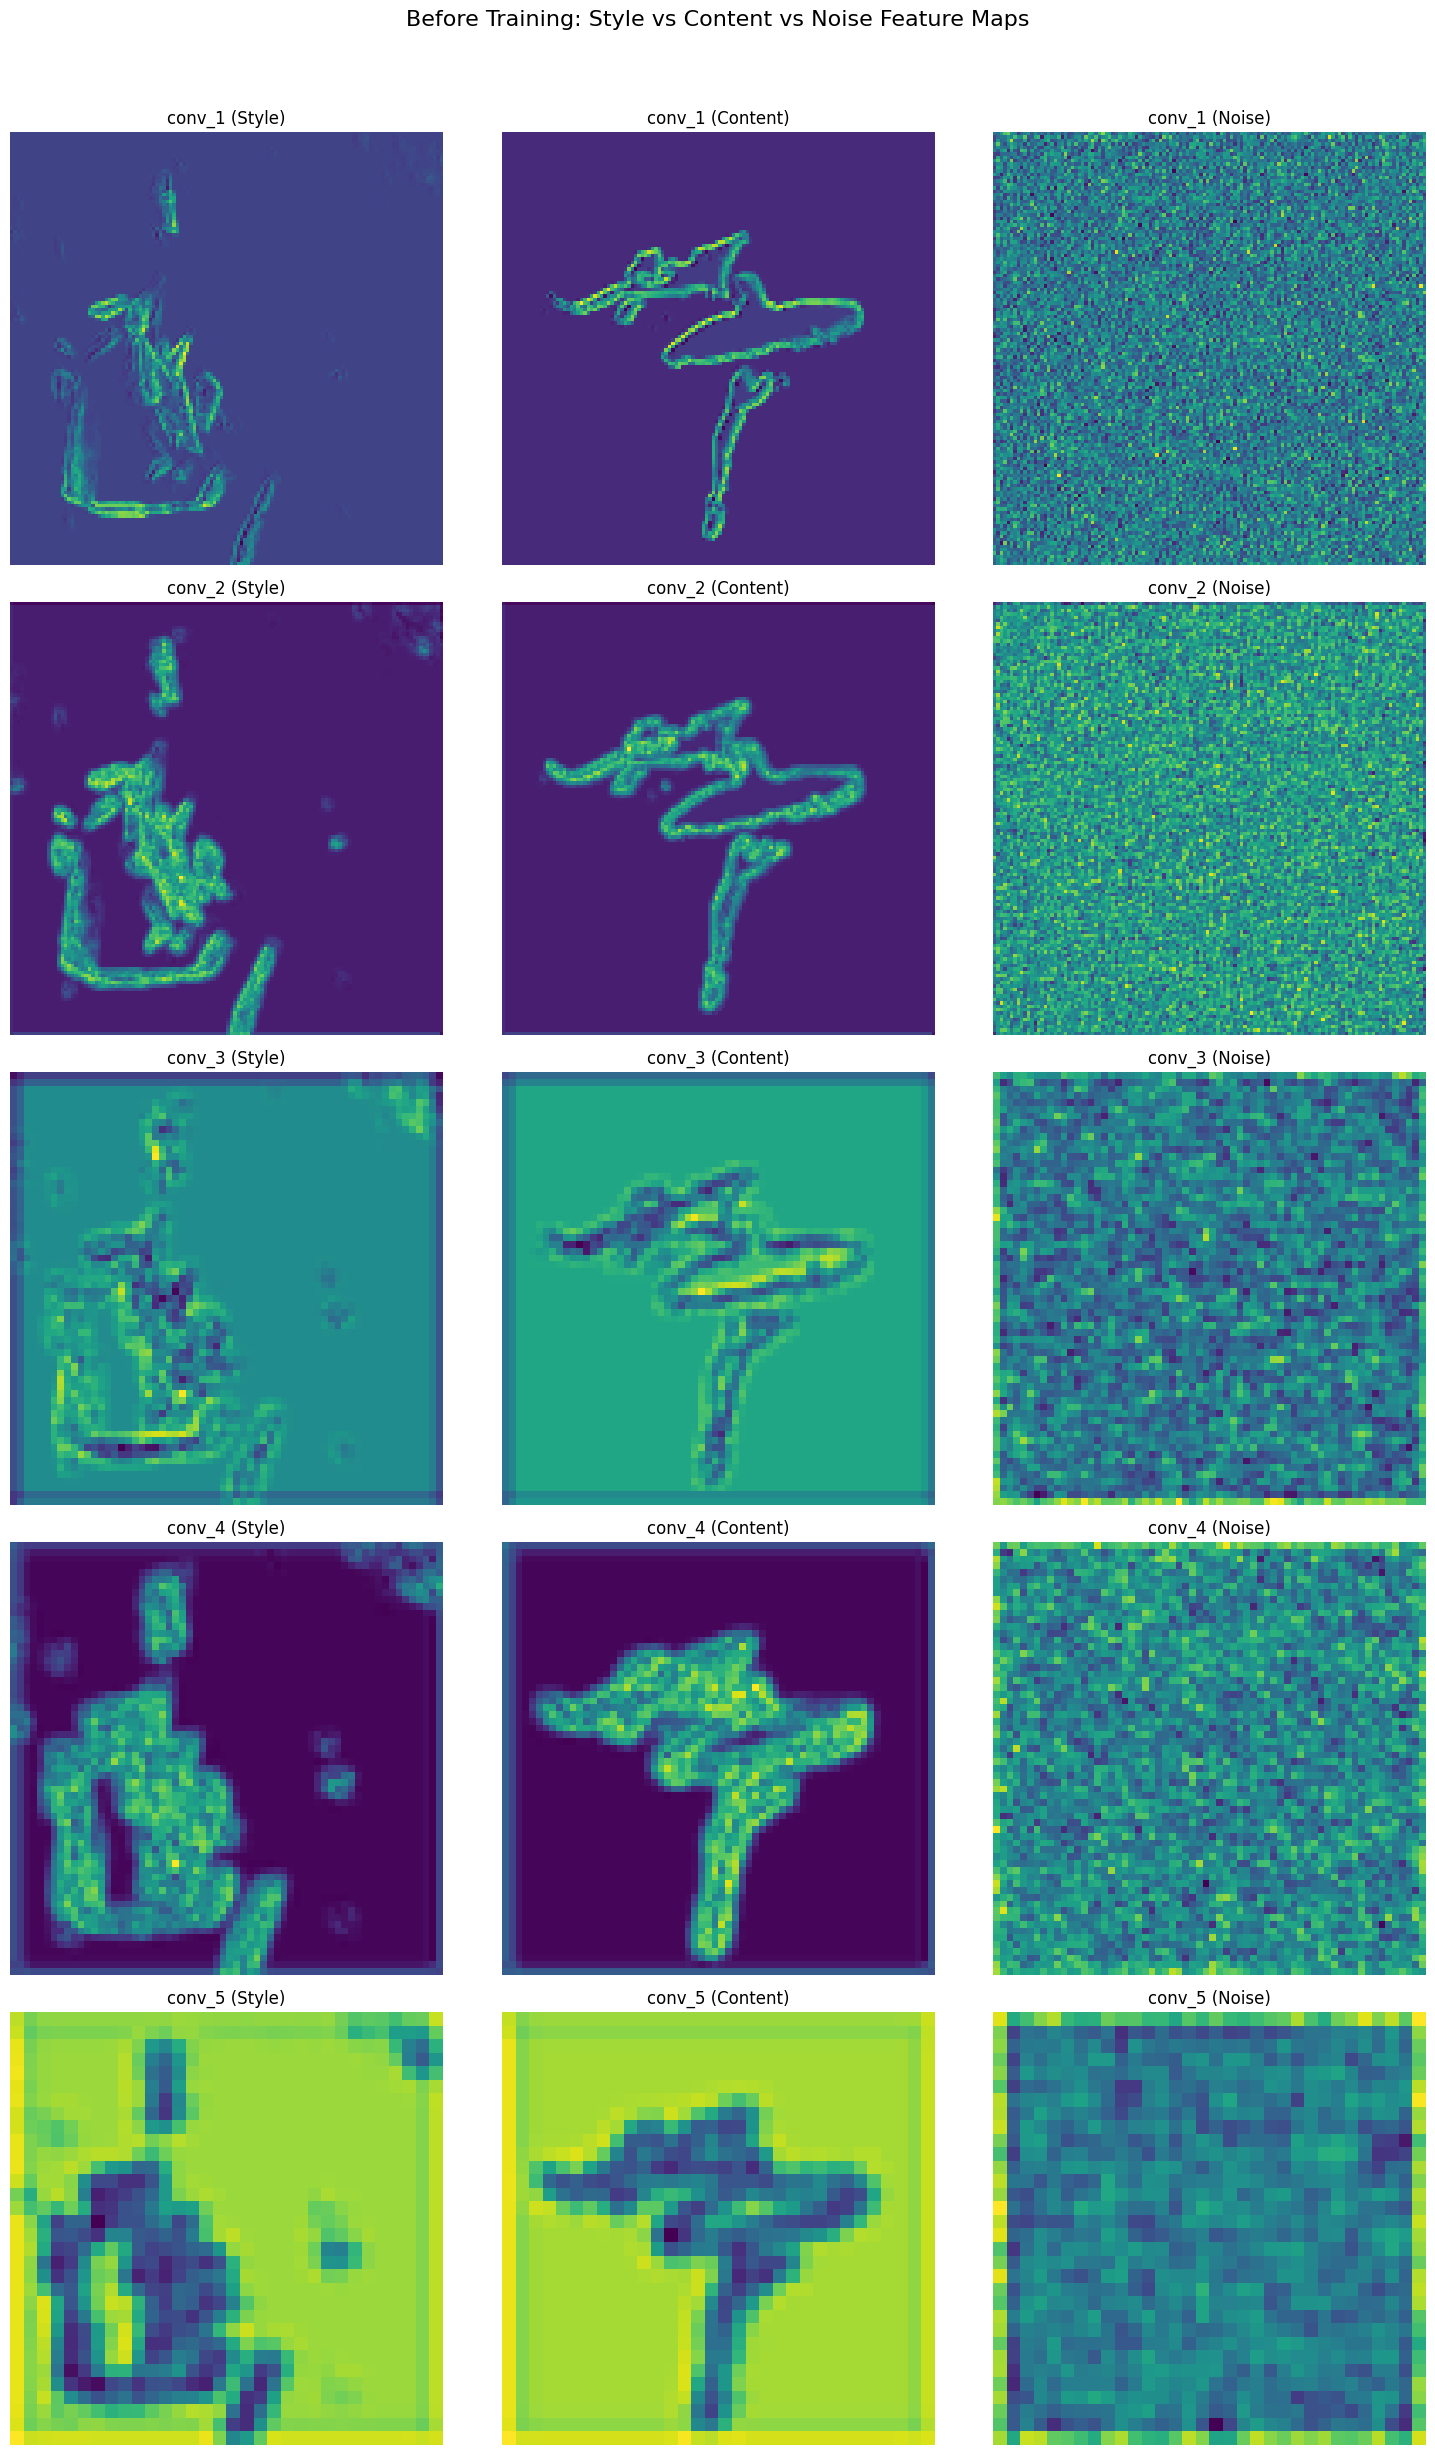

In [13]:
visualize_feature_maps(style_tensor_feature_maps, content_tensor_feature_maps, noise_tensor_feature_maps)

# 3. Define loss function

## 3-1. Style loss

## Gram Matrix 비유: 페인팅

### 페인트의 색상과 질감(채널)
- 화가가 그림을 그릴 때 사용한 다양한 **색상과 질감**이 그림의 스타일을 결정합니다.
- 피처맵의 각 채널은 그림의 특정 **색상이나 질감**을 표현한다고 생각할 수 있습니다.

### 색상 간의 관계
- 스타일은 단순히 어떤 색상이 쓰였는지가 아니라, **색상들 간의 관계와 조화**에서 나옵니다.
- 예를 들어:
  - **파란색과 노란색**이 부드럽게 섞이면 차분한 스타일.
  - **빨간색과 검은색**이 강하게 대조되면 강렬한 스타일.
- Gram Matrix는 이러한 **색상 간의 상관관계**를 수치적으로 캡처합니다.

### 그림의 위치 정보 제거
- 스타일은 그림의 구체적인 **위치**와 상관없이, 색상과 질감의 전반적인 **조화**로 정의됩니다.
- Gram Matrix는 위치 정보(공간적 구조)를 무시하고, 스타일의 본질인 **조화와 패턴**만 남깁니다.


In [14]:
def gram_matrix(feature_map):
    batch, channel, height, width = feature_map.size()

    features = feature_map.view(batch * channel, height * width)
    G = torch.mm(features, features.t())

    return G.div(batch * channel * height * width)

In [15]:
def style_loss(input, target):
    input_G = gram_matrix(input)
    target_G = gram_matrix(target)

    loss = F.mse_loss(input_G, target_G)

    return loss

## 3-2. Content loss

In [16]:
def content_loss(input, target):
    return F.mse_loss(input, target)

# 4. Training

## 4-1. Train 

In [17]:
required_noise_tensor = noise_tensor.clone().to(device)
required_noise_tensor.requires_grad_(True)

optimizer = optim.SGD([required_noise_tensor], lr=0.001)

style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
content_layers = ['conv_4']
style_weight = 1000000
content_weight = 1
epochs = 300
for epoch in range(epochs):
    optimizer.zero_grad()

    output = required_noise_tensor
    with torch.no_grad():
        output.clamp_(0, 1)

    style_losses = 0.0
    content_losses = 0.0
    for name, layer in model.named_children():
        output = layer(output)

        if name in style_layers:
            style_losses += style_loss(output, style_tensor_feature_maps[name].detach())

        if name in content_layers:
            content_losses += content_loss(output, content_tensor_feature_maps[name].detach())

    style_losses *= style_weight
    content_losses *= content_weight

    loss = style_losses + content_losses
    loss.backward()

    optimizer.step()

    if epoch % 50 == 0:
        print(f"{epoch}/{epochs} loss: {loss.item():.4f} style_loss: {style_losses.item():.4f} content_loss: {content_losses.item():.4f}")

with torch.no_grad():
    output.clamp_(0, 1)

0/50 loss: 129.6558 style_loss: 122.5014 content_loss: 7.1543


## 4-2. Visualizae feature maps

In [18]:
def visualize_feature_maps(style_results, content_results, noise_results, layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    fig, axes = plt.subplots(len(layers), 3, figsize=(15, 5 * len(layers)))
    fig.suptitle("After Training: Style vs Content vs Noise Feature Maps", fontsize=16)

    if len(layers) == 1:
        axes = [axes]

    for i, layer in enumerate(layers):
        # Style feature map
        style_feature_map = style_results[layer].squeeze(0).cpu()
        style_mean_map = torch.mean(style_feature_map, dim=0).detach().numpy()
        axes[i][0].imshow(style_mean_map, cmap="viridis")
        axes[i][0].set_title(f"{layer} (Style)")
        axes[i][0].axis("off")

        # Content feature map
        content_feature_map = content_results[layer].squeeze(0).cpu()
        content_mean_map = torch.mean(content_feature_map, dim=0).detach().numpy()
        axes[i][1].imshow(content_mean_map, cmap="viridis")
        axes[i][1].set_title(f"{layer} (Content)")
        axes[i][1].axis("off")

        # Noise feature map
        noise_feature_map = noise_results[layer].squeeze(0).cpu()
        noise_mean_map = torch.mean(noise_feature_map, dim=0).detach().numpy()
        axes[i][2].imshow(noise_mean_map, cmap="viridis")
        axes[i][2].set_title(f"{layer} (Noise)")
        axes[i][2].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [19]:
noise_tensor_feature_map = required_noise_tensor
noise_tensor_feature_maps = {}

for name, layer in model.named_children():
    with torch.no_grad():
        noise_tensor_feature_map.clamp_(0, 1)

    noise_tensor_feature_map = layer(noise_tensor_feature_map)
    noise_tensor_feature_maps[name] = noise_tensor_feature_map

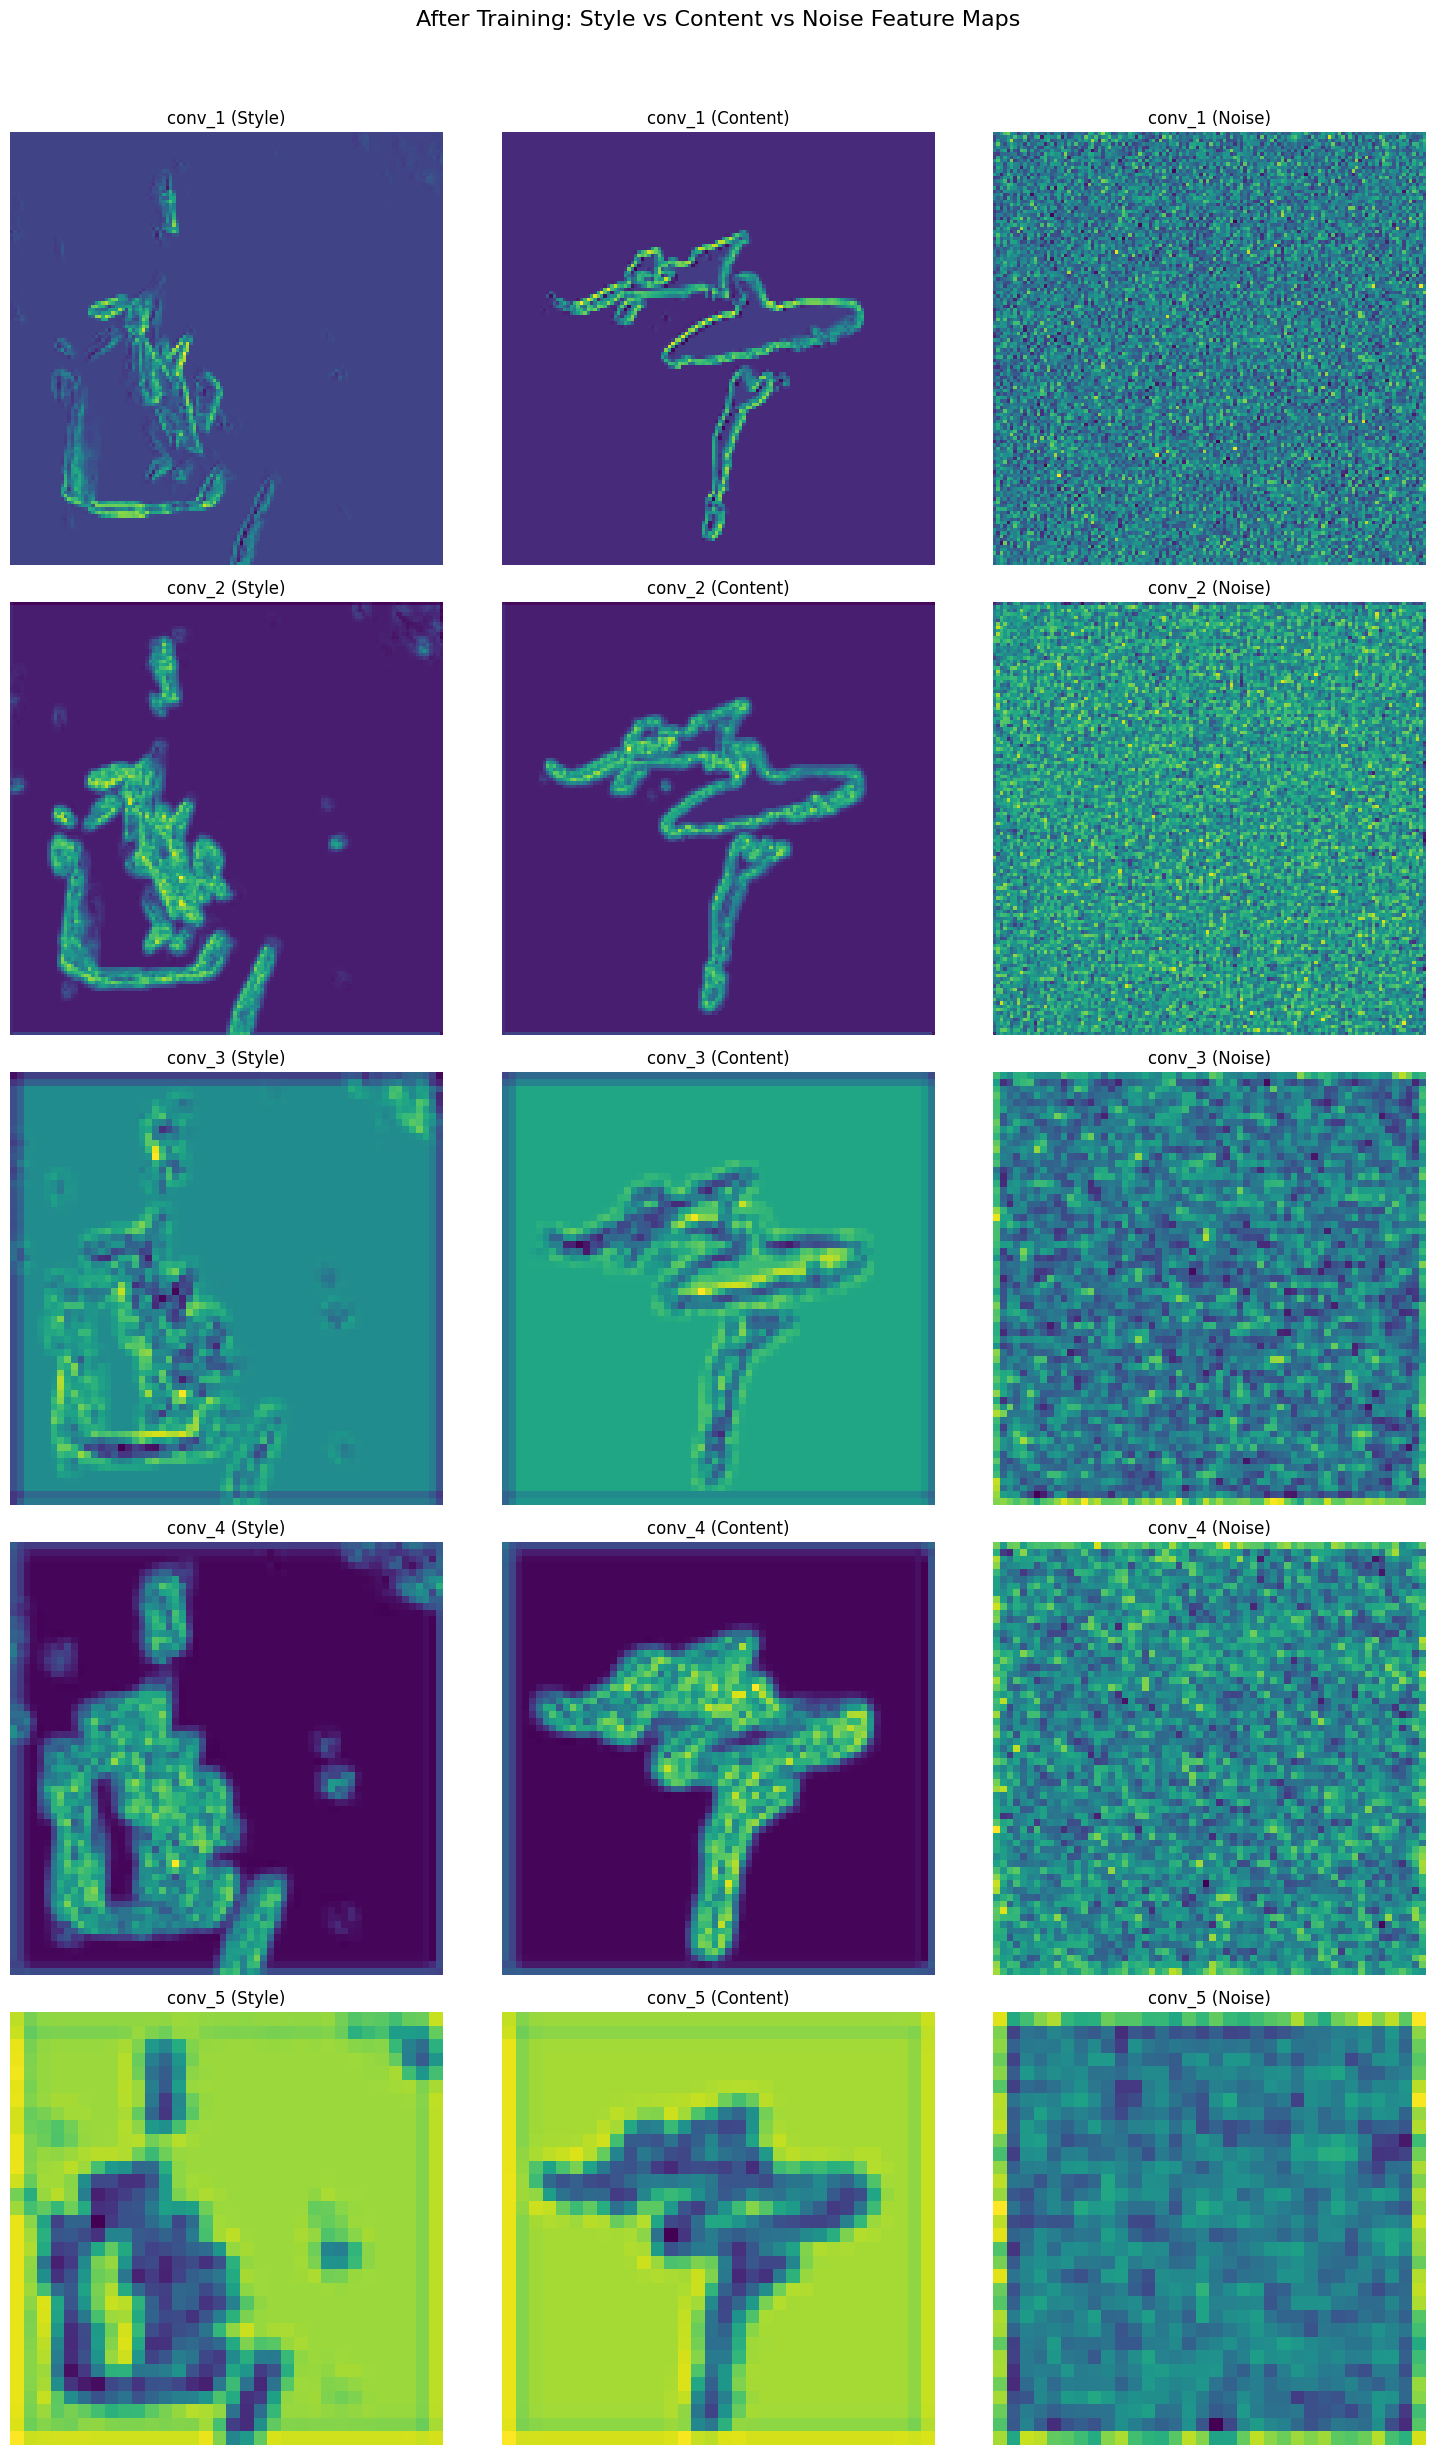

In [20]:
visualize_feature_maps(style_tensor_feature_maps, content_tensor_feature_maps, noise_tensor_feature_maps)

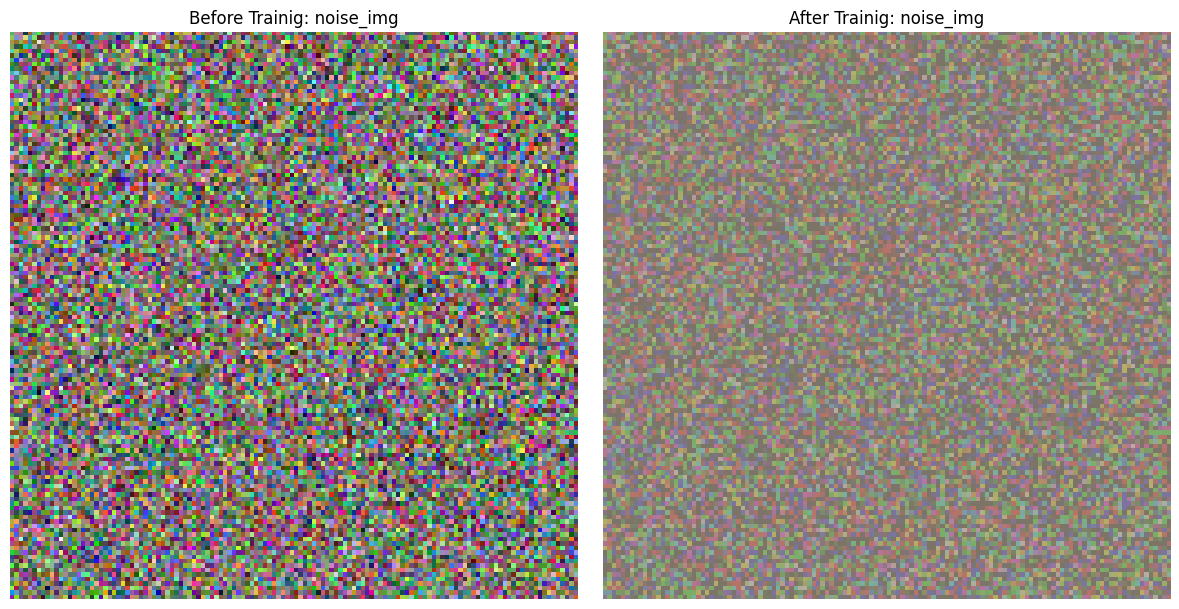

In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(untransform(noise_tensor.squeeze(0)))
plt.title("Before Trainig: noise_img")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(untransform(required_noise_tensor.squeeze(0)))
plt.title("After Trainig: noise_img")
plt.axis("off")

plt.tight_layout()
plt.show()